C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\985127038.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\985127038.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pr

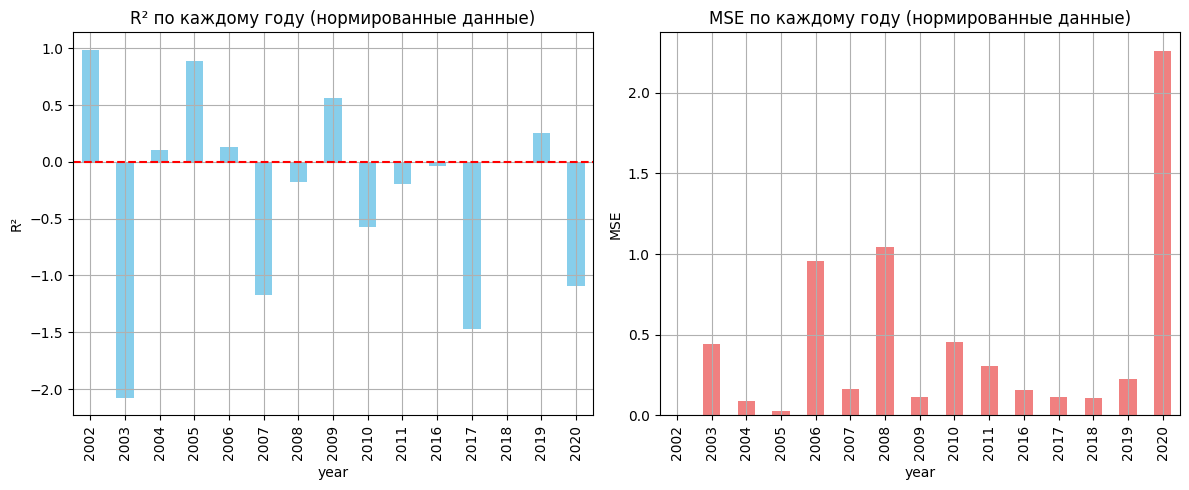

MSE: 0.3485
RMSE: 0.5903
R²: 0.1647


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"
s1_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_3000_матрица_из_ячеек_все_годы.csv"
s2_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_4500_матрица_из_ячеек_все_годы.csv"
s3_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_6000_матрица_из_ячеек_все_годы.csv"

df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

r_all = r1.merge(r2, on='date').merge(r3, on='date')
r_features = r_all[['R1', 'R2', 'R3']]
r_p95 = r_features.quantile(0.99)
r_clipped = r_features.clip(upper=r_p95, axis=1)
r_normalized = r_clipped / r_p95
r_normalized['date'] = r_all['date']

def load_s(path, name):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df.columns = [f'{name}_{col}' for col in df.columns]
    return df

s1 = load_s(s1_path, 'S1')
s2 = load_s(s2_path, 'S2')
s3 = load_s(s3_path, 'S3')

df_x = r_normalized.copy()
df_x = df_x.set_index('date')
df_x = df_x.join([s1, s2, s3])
df_x = df_x.reset_index()

df = pd.merge(df_x, df_y, on='date', how='inner')
df = df.dropna(subset=['chlorophyll'])

features = df.drop(columns=['date', 'chlorophyll', 'R1', 'R2', 'R3'])  # только S
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

X_scaled = pd.concat([df[['R1', 'R2', 'R3']].reset_index(drop=True), features_scaled], axis=1)
X_scaled['date'] = df['date'].values
y = df['chlorophyll']
groups = df['date'].dt.year

model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
logo = LeaveOneGroupOut()
y_pred = cross_val_predict(model, X_scaled.drop(columns='date'), y, cv=logo, groups=groups)

df_result = df[['date']].copy()
df_result['y_true'] = y
df_result['y_pred'] = y_pred
df_result['year'] = df_result['date'].dt.year

r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
r2_by_year.plot(kind='bar', color='skyblue')
plt.axhline(0, color='red', linestyle='--')
plt.title('R² по каждому году (нормированные данные)')
plt.ylabel('R²')
plt.grid(True)

plt.subplot(1, 2, 2)
mse_by_year.plot(kind='bar', color='lightcoral')
plt.title('MSE по каждому году (нормированные данные)')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
rr2 = r2_score(y, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {rr2:.4f}")


C:\Users\fusb1\AppData\Local\Temp\ipykernel_9976\1852307042.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_9976\1852307042.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_

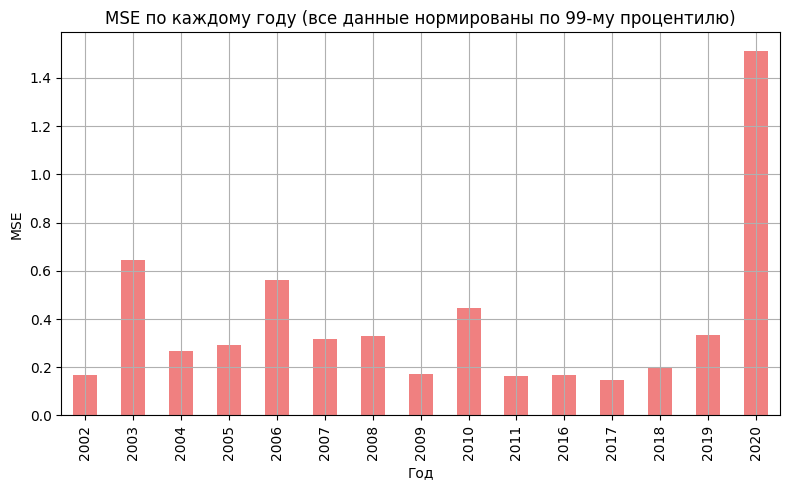

MSE: 0.3193
RMSE: 0.5651
R²: 0.0639


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Загрузка данных
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"
s1_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_3000_матрица_из_ячеек_все_годы.csv"
s2_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_4500_матрица_из_ячеек_все_годы.csv"
s3_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_6000_матрица_из_ячеек_все_годы.csv"

df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

r_all = r1.merge(r2, on='date').merge(r3, on='date')
r_all = r_all.set_index('date')

def load_s(path, name):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df.columns = [f'{name}_{col}' for col in df.columns]
    return df

s1 = load_s(s1_path, 'S1')
s2 = load_s(s2_path, 'S2')
s3 = load_s(s3_path, 'S3')

# Объединяем все признаки
df_x = pd.concat([r_all, s1, s2, s3], axis=1).reset_index()

# Объединяем с целевой переменной
df = pd.merge(df_x, df_y, on='date', how='inner')
df = df.dropna(subset=['chlorophyll'])

# Подготовка признаков
features = df.drop(columns=['date', 'chlorophyll'])
p99 = features.quantile(0.99)
features_clipped = features.clip(upper=p99, axis=1)
features_normalized = features_clipped / p99

# Формируем финальные X и y
X = features_normalized
y = df['chlorophyll']
groups = df['date'].dt.year

# Модель и кросс-валидация
model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
logo = LeaveOneGroupOut()
y_pred = cross_val_predict(model, X, y, cv=logo, groups=groups)

# Результаты
df_result = df[['date']].copy()
df_result['y_true'] = y
df_result['y_pred'] = y_pred
df_result['year'] = df_result['date'].dt.year

r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

# График MSE по годам
plt.figure(figsize=(8, 5))
mse_by_year.plot(kind='bar', color='lightcoral')
plt.title('MSE по каждому году (все данные нормированы по 99-му процентилю)')
plt.ylabel('MSE')
plt.xlabel('Год')
plt.grid(True)
plt.tight_layout()
plt.show()

# Итоговые метрики
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
rr2 = r2_score(y, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {rr2:.4f}")


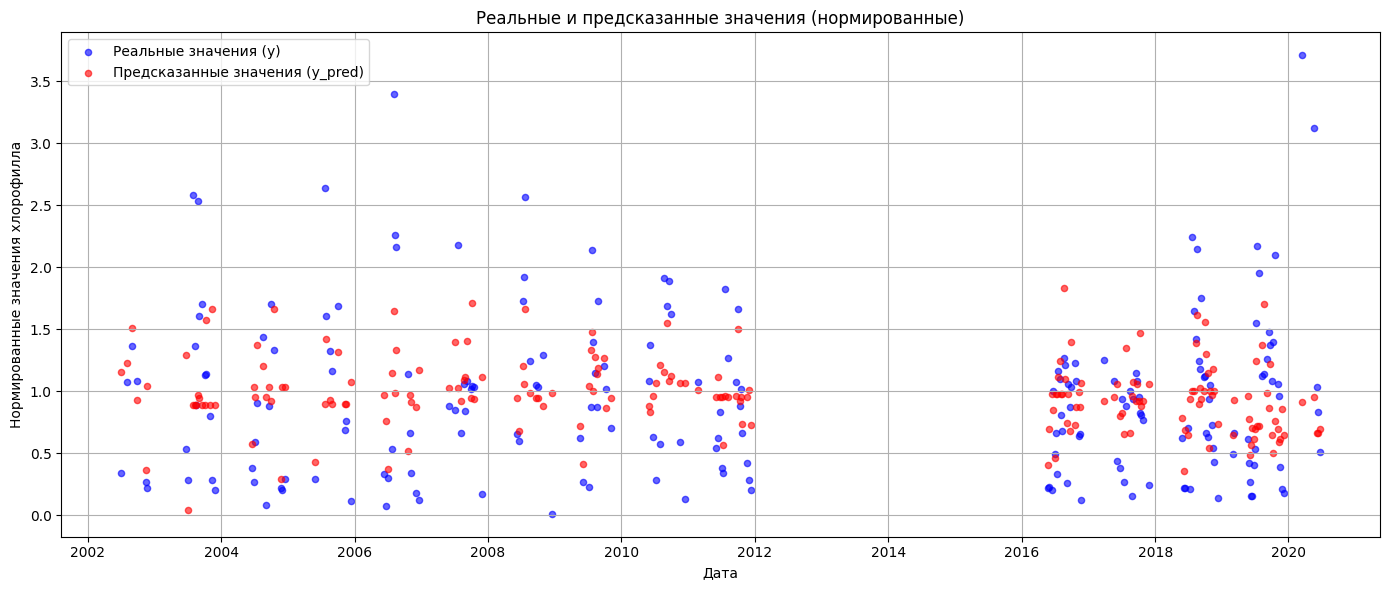

In [8]:
# Временной график: Реальные vs Предсказанные значения (ТОЧКИ)
plt.figure(figsize=(14, 6))
plt.scatter(df_result['date'], df_result['y_true'], label='Реальные значения (y)', color='blue', alpha=0.6, s=20)
plt.scatter(df_result['date'], df_result['y_pred'], label='Предсказанные значения (y_pred)', color='red', alpha=0.6, s=20)
plt.title('Реальные и предсказанные значения (нормированные)')
plt.xlabel('Дата')
plt.ylabel('Нормированные значения хлорофилла')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [14]:
print(">>> Размерности R")
print("r1 shape:", r1.shape)
print("r2 shape:", r2.shape)
print("r3 shape:", r3.shape)

print("\n>>> Уникальные даты в R")
print("r1 dates:", r1['date'].nunique())
print("r2 dates:", r2['date'].nunique())
print("r3 dates:", r3['date'].nunique())

print("\n>>> Пересечение всех R по дате")
r_intersection = r1.merge(r2, on='date').merge(r3, on='date')
print("r_intersection shape:", r_intersection.shape)
print("Уникальные даты в пересечении:", r_intersection['date'].nunique())

>>> Размерности R
r1 shape: (729, 2)
r2 shape: (790, 2)
r3 shape: (857, 2)

>>> Уникальные даты в R
r1 dates: 729
r2 dates: 790
r3 dates: 857

>>> Пересечение всех R по дате
r_intersection shape: (729, 4)
Уникальные даты в пересечении: 729


In [15]:
print("\n>>> Размерность Y")
print("df_y shape:", df_y.shape)
print("Уникальные даты в Y:", df_y['date'].nunique())


>>> Размерность Y
df_y shape: (780, 2)
Уникальные даты в Y: 780


In [16]:
print("\n>>> Размерности S")
print("s1 shape:", s1.shape)
print("s2 shape:", s2.shape)
print("s3 shape:", s3.shape)

print("\n>>> Уникальные даты в S")
print("s1 dates:", s1.index.nunique())
print("s2 dates:", s2.index.nunique())
print("s3 dates:", s3.index.nunique())


>>> Размерности S
s1 shape: (2364, 3866)
s2 shape: (1678, 1774)
s3 shape: (408, 819)

>>> Уникальные даты в S
s1 dates: 2364
s2 dates: 1678
s3 dates: 408


In [17]:
print("\n>>> Размерности финальных признаков и таргета")
print("X_scaled shape:", X_scaled.shape)
print("features_scaled shape:", features_scaled.shape)
print("y shape:", y.shape)


>>> Размерности финальных признаков и таргета
X_scaled shape: (70, 6463)
features_scaled shape: (70, 6459)
y shape: (70,)


In [18]:
print(f"Количество уникальных дат в df_y: {df_y['date'].nunique()}")
print(f"Количество уникальных дат в df_x: {df_x['date'].nunique()}")
print(f"Количество строк после объединения: {df.shape[0]}")


Количество уникальных дат в df_y: 780
Количество уникальных дат в df_x: 729
Количество строк после объединения: 70


Количество уникальных дат в Y (df_y): 780
Количество уникальных дат в R (r_normalized): 729
Количество уникальных дат в S1: 2364
Количество уникальных дат в S2: 1678
Количество уникальных дат в S3: 408

Количество уникальных дат после объединения R и S (df_x): 729
Количество строк после объединения с Y (df): 70


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\3931990265.py:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\3931990265.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_

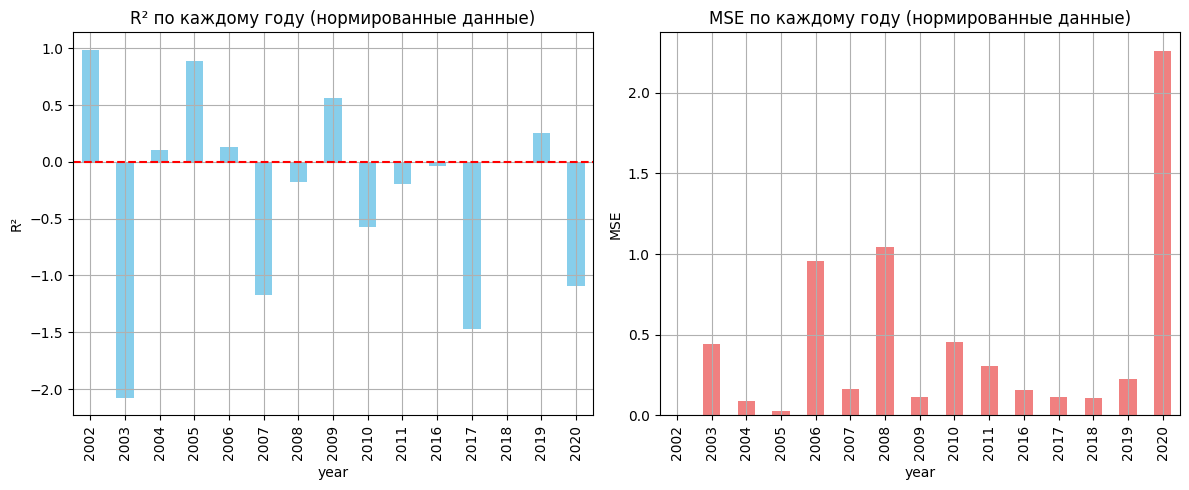

MSE: 0.3485
RMSE: 0.5903
R²: 0.1647


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"
s1_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_3000_матрица_из_ячеек_все_годы.csv"
s2_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_4500_матрица_из_ячеек_все_годы.csv"
s3_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_6000_матрица_из_ячеек_все_годы.csv"

df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

r_all = r1.merge(r2, on='date').merge(r3, on='date')
r_features = r_all[['R1', 'R2', 'R3']]
r_p95 = r_features.quantile(0.99)
r_clipped = r_features.clip(upper=r_p95, axis=1)
r_normalized = r_clipped / r_p95
r_normalized['date'] = r_all['date']

def load_s(path, name):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df.columns = [f'{name}_{col}' for col in df.columns]
    return df

s1 = load_s(s1_path, 'S1')
s2 = load_s(s2_path, 'S2')
s3 = load_s(s3_path, 'S3')

df_x = r_normalized.copy()
df_x = df_x.set_index('date')
df_x = df_x.join([s1, s2, s3])
df_x = df_x.reset_index()

# Размерности исходных таблиц
print(f"Количество уникальных дат в Y (df_y): {df_y['date'].nunique()}")
print(f"Количество уникальных дат в R (r_normalized): {r_normalized['date'].nunique()}")
print(f"Количество уникальных дат в S1: {s1.index.nunique()}")
print(f"Количество уникальных дат в S2: {s2.index.nunique()}")
print(f"Количество уникальных дат в S3: {s3.index.nunique()}")

# После объединения R и S (df_x)
print(f"\nКоличество уникальных дат после объединения R и S (df_x): {df_x['date'].nunique()}")

# После объединения с Y
print(f"Количество строк после объединения с Y (df): {df.shape[0]}")


df = pd.merge(df_x, df_y, on='date', how='inner')
df = df.dropna(subset=['chlorophyll'])

features = df.drop(columns=['date', 'chlorophyll', 'R1', 'R2', 'R3'])  # только S
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

X_scaled = pd.concat([df[['R1', 'R2', 'R3']].reset_index(drop=True), features_scaled], axis=1)
X_scaled['date'] = df['date'].values
y = df['chlorophyll']
groups = df['date'].dt.year

model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
logo = LeaveOneGroupOut()
y_pred = cross_val_predict(model, X_scaled.drop(columns='date'), y, cv=logo, groups=groups)

df_result = df[['date']].copy()
df_result['y_true'] = y
df_result['y_pred'] = y_pred
df_result['year'] = df_result['date'].dt.year

r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
r2_by_year.plot(kind='bar', color='skyblue')
plt.axhline(0, color='red', linestyle='--')
plt.title('R² по каждому году (нормированные данные)')
plt.ylabel('R²')
plt.grid(True)

plt.subplot(1, 2, 2)
mse_by_year.plot(kind='bar', color='lightcoral')
plt.title('MSE по каждому году (нормированные данные)')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
rr2 = r2_score(y, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {rr2:.4f}")



>>> Размерности исходных таблиц
Количество уникальных дат в Y (df_y): 780
Количество уникальных дат в R (r_normalized): 729

Количество строк после объединения R и Y (df): 70
Количество уникальных дат после объединения (df): 70


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\4103356465.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\4103356465.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_

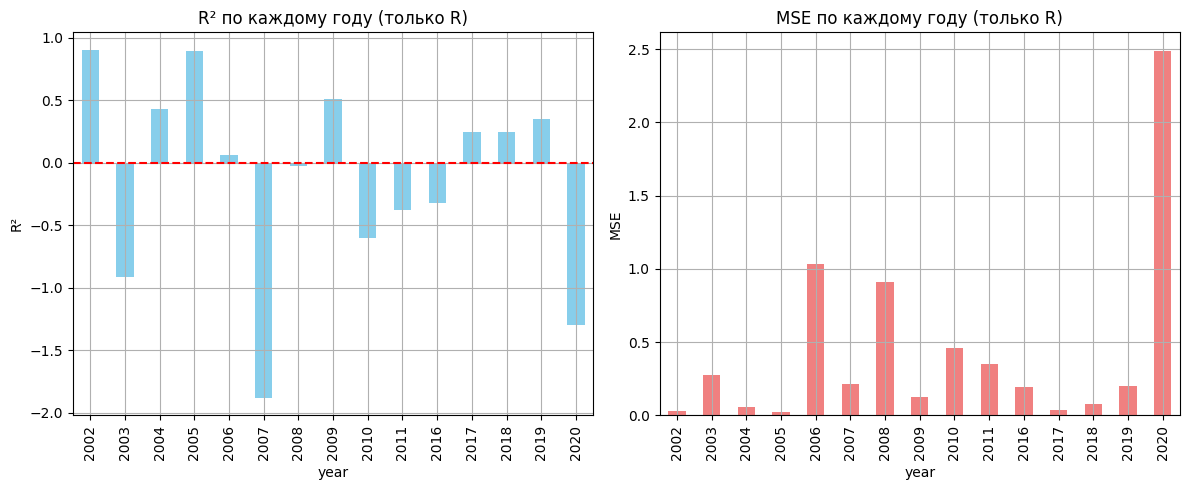

MSE: 0.3472
RMSE: 0.5893
R²: 0.1677


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Пути к файлам
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"

# Загрузка Y
df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

# Загрузка R
def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

# Объединение всех R
r_all = r1.merge(r2, on='date').merge(r3, on='date')
r_features = r_all[['R1', 'R2', 'R3']]

# Нормализация с обрезкой по 99-му процентилю
r_p95 = r_features.quantile(0.99)
r_clipped = r_features.clip(upper=r_p95, axis=1)
r_normalized = r_clipped / r_p95
r_normalized['date'] = r_all['date']

# Объединение с Y
df = pd.merge(r_normalized, df_y, on='date', how='inner')
df = df.dropna(subset=['chlorophyll'])

# Проверка размерностей и количества уникальных дат

print("\n>>> Размерности исходных таблиц")
print(f"Количество уникальных дат в Y (df_y): {df_y['date'].nunique()}")
print(f"Количество уникальных дат в R (r_normalized): {r_normalized['date'].nunique()}")

# После объединения R и Y
print(f"\nКоличество строк после объединения R и Y (df): {df.shape[0]}")
print(f"Количество уникальных дат после объединения (df): {df['date'].nunique()}")

# Подготовка данных
X = df[['R1', 'R2', 'R3']]
y = df['chlorophyll']
groups = df['date'].dt.year

# Модель и кросс-валидация
model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
logo = LeaveOneGroupOut()
y_pred = cross_val_predict(model, X, y, cv=logo, groups=groups)

# Результаты по годам
df_result = df[['date']].copy()
df_result['y_true'] = y
df_result['y_pred'] = y_pred
df_result['year'] = df_result['date'].dt.year

r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

# Графики
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
r2_by_year.plot(kind='bar', color='skyblue')
plt.axhline(0, color='red', linestyle='--')
plt.title('R² по каждому году (только R)')
plt.ylabel('R²')
plt.grid(True)

plt.subplot(1, 2, 2)
mse_by_year.plot(kind='bar', color='lightcoral')
plt.title('MSE по каждому году (только R)')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()

# Итоговые метрики
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")



>>> Размерности исходных таблиц после агрегации по неделям
Количество уникальных недель в Y (y_weekly): 769
Количество уникальных недель в R (r_weekly): 392

Количество строк после объединения R и Y (df): 230
Количество уникальных дат после объединения (df): 230


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\75576442.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\75576442.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred

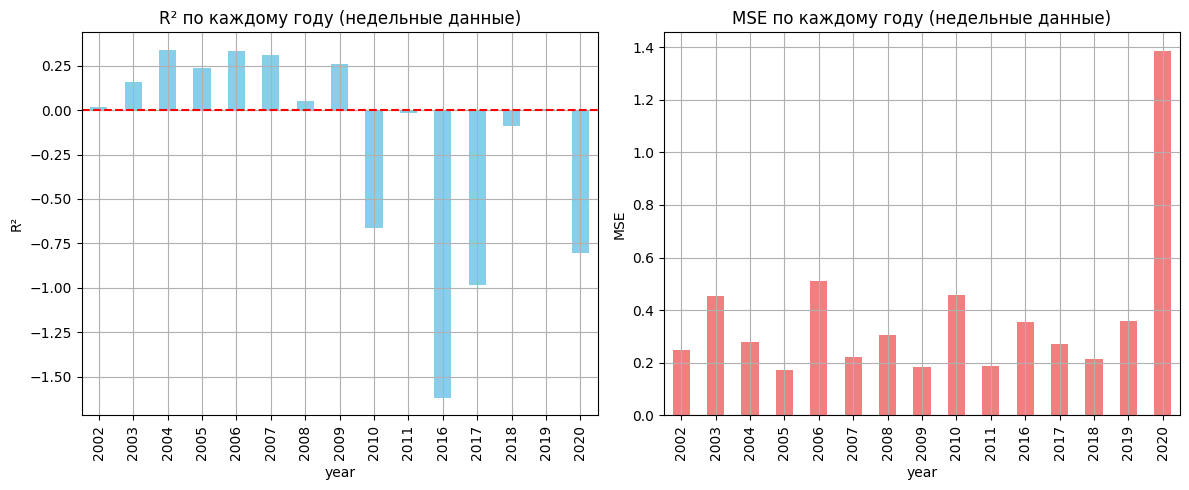

MSE: 0.3234
RMSE: 0.5687
R²: 0.0252


In [23]:
#по неделям


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Пути к данным
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"

# Загрузка Y
df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

# Загрузка R и нормализация
def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

r_all = r1.merge(r2, on='date').merge(r3, on='date')
r_features = r_all[['R1', 'R2', 'R3']]
r_p95 = r_features.quantile(0.99)
r_clipped = r_features.clip(upper=r_p95, axis=1)
r_normalized = r_clipped / r_p95
r_normalized['date'] = r_all['date']

# --- Агрегация по неделям ---
df_y['week'] = df_y['date'].dt.to_period('W').dt.start_time
r_normalized['week'] = r_normalized['date'].dt.to_period('W').dt.start_time

y_weekly = df_y.groupby('week')['chlorophyll'].mean().reset_index()
r_weekly = r_normalized.groupby('week')[['R1', 'R2', 'R3']].mean().reset_index()

# Объединяем по неделям
df = pd.merge(r_weekly, y_weekly, on='week', how='inner')
df = df.rename(columns={'week': 'date'})

# --- Выводим размерности ---
print("\n>>> Размерности исходных таблиц после агрегации по неделям")
print(f"Количество уникальных недель в Y (y_weekly): {y_weekly['week'].nunique()}")
print(f"Количество уникальных недель в R (r_weekly): {r_weekly['week'].nunique()}")
print(f"\nКоличество строк после объединения R и Y (df): {df.shape[0]}")
print(f"Количество уникальных дат после объединения (df): {df['date'].nunique()}")

# --- Модель (если нужно) ---
features = df[['R1', 'R2', 'R3']]
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

X_scaled = features_scaled
y = df['chlorophyll']
groups = df['date'].dt.year

model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
logo = LeaveOneGroupOut()
y_pred = cross_val_predict(model, X_scaled, y, cv=logo, groups=groups)

df_result = df[['date']].copy()
df_result['y_true'] = y
df_result['y_pred'] = y_pred
df_result['year'] = df_result['date'].dt.year

r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
r2_by_year.plot(kind='bar', color='skyblue')
plt.axhline(0, color='red', linestyle='--')
plt.title('R² по каждому году (недельные данные)')
plt.ylabel('R²')
plt.grid(True)

plt.subplot(1, 2, 2)
mse_by_year.plot(kind='bar', color='lightcoral')
plt.title('MSE по каждому году (недельные данные)')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")



>>> Размерности после агрегации по неделям и нормализации по 99 перцентилю
Количество уникальных недель в Y (y_weekly): 769
Количество уникальных недель в R (r_weekly): 392

Количество строк после объединения R и Y (df): 230
Количество уникальных дат после объединения (df): 230


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\463476799.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\463476799.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pr

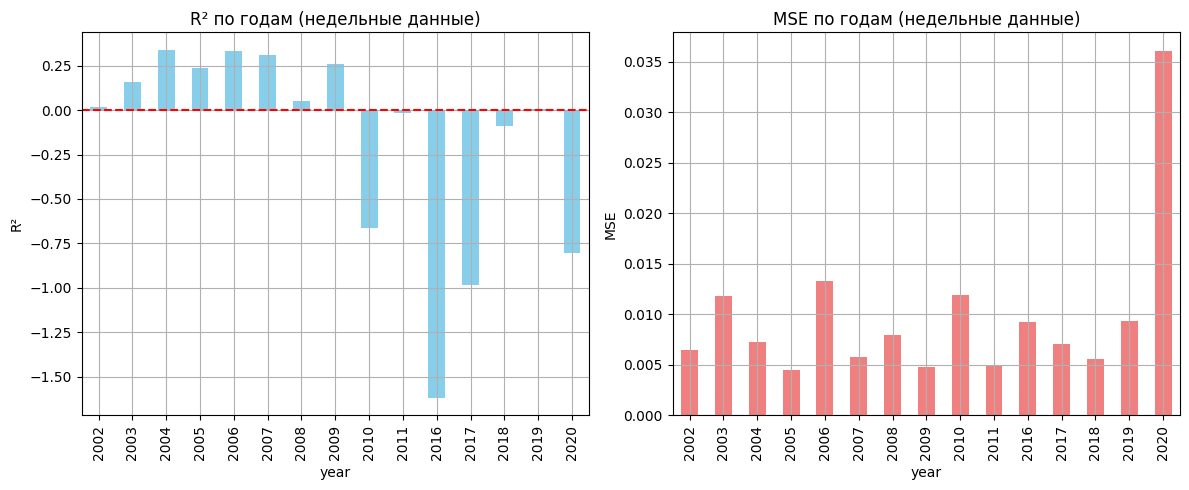

MSE: 0.0084
RMSE: 0.0918
R²: 0.0252

Размерности и количество уникальных дат:
Уникальных недель в df: 230
Размер df: (230, 5)


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Пути к данным
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"

# Загрузка Y
df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

# Загрузка R
def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

# Объединяем R
r_all = r1.merge(r2, on='date').merge(r3, on='date')

# --- Нормализуем R по 99 перцентилю ДО агрегации ---
cols_r = ['R1', 'R2', 'R3']
p99_r = r_all[cols_r].quantile(0.99)
r_all[cols_r] = r_all[cols_r].clip(upper=p99_r, axis=1)
r_all[cols_r] = r_all[cols_r].div(p99_r, axis=1)


# Нормализуем Y по 99 перцентилю ДО агрегации
p99_y = df_y['chlorophyll'].quantile(0.99)
df_y['chlorophyll'] = df_y['chlorophyll'].clip(upper=p99_y)
df_y['chlorophyll'] = df_y['chlorophyll'] / p99_y


# Добавляем колонки недели (начало недели)
df_y['week'] = df_y['date'].dt.to_period('W').dt.start_time
r_all['week'] = r_all['date'].dt.to_period('W').dt.start_time

# Агрегируем по неделям (усреднение)
y_weekly = df_y.groupby('week')['chlorophyll'].mean().reset_index()
r_weekly = r_all.groupby('week')[cols_r].mean().reset_index()

# Объединяем по неделям
df = pd.merge(r_weekly, y_weekly, on='week', how='inner')
df = df.rename(columns={'week': 'date'})

# --- Вывод размерностей ---
print("\n>>> Размерности после агрегации по неделям и нормализации по 99 перцентилю")
print(f"Количество уникальных недель в Y (y_weekly): {y_weekly['week'].nunique()}")
print(f"Количество уникальных недель в R (r_weekly): {r_weekly['week'].nunique()}")
print(f"\nКоличество строк после объединения R и Y (df): {df.shape[0]}")
print(f"Количество уникальных дат после объединения (df): {df['date'].nunique()}")

# --- Модель ---
X = df[cols_r]
y = df['chlorophyll']
groups = df['date'].dt.year

model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
logo = LeaveOneGroupOut()

y_pred = cross_val_predict(model, X, y, cv=logo, groups=groups)

# Результаты
df_result = df[['date']].copy()
df_result['y_true'] = y
df_result['y_pred'] = y_pred
df_result['year'] = df_result['date'].dt.year

r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
r2_by_year.plot(kind='bar', color='skyblue')
plt.axhline(0, color='red', linestyle='--')
plt.title('R² по годам (недельные данные)')
plt.ylabel('R²')
plt.grid(True)

plt.subplot(1, 2, 2)
mse_by_year.plot(kind='bar', color='lightcoral')
plt.title('MSE по годам (недельные данные)')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()

# Итоговые метрики
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

print("\nРазмерности и количество уникальных дат:")
print(f"Уникальных недель в df: {df['date'].nunique()}")
print(f"Размер df: {df.shape}")


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\1063721261.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\1063721261.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_


R² по годам:
year
2002    0.017837
2003    0.157719
2004    0.340281
2005    0.237266
2006    0.333457
2007    0.310283
2008    0.049359
2009    0.258688
2010   -0.666280
2011   -0.017567
2016   -1.621133
2017   -0.984688
2018   -0.090560
2019    0.006100
2020   -0.807020
dtype: float64

MSE по годам:
year
2002    0.006485
2003    0.011848
2004    0.007271
2005    0.004526
2006    0.013327
2007    0.005832
2008    0.007959
2009    0.004823
2010    0.011908
2011    0.004938
2016    0.009278
2017    0.007088
2018    0.005548
2019    0.009343
2020    0.036119
dtype: float64


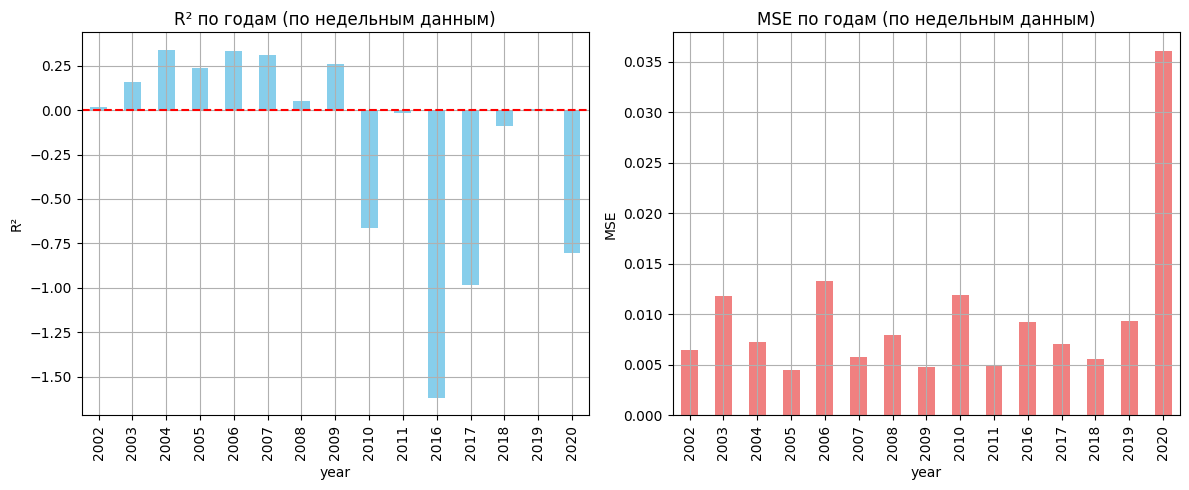


Итоговые метрики по всем данным:
MSE: 0.0084
RMSE: 0.0918
R²: 0.0252

Размерности и количество уникальных недель:
Уникальных недель в df_weekly: 230
Размер df_weekly: (230, 5)


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Пути к файлам
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"

# Загрузка Y
df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

# Функция загрузки R
def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

# Нормализуем Y ДО агрегации
p99_y = df_y['chlorophyll'].quantile(0.99)
df_y['chlorophyll'] = df_y['chlorophyll'].clip(upper=p99_y)
df_y['chlorophyll'] = df_y['chlorophyll'] / p99_y
df_y['week'] = df_y['date'].dt.to_period('W').apply(lambda r: r.start_time)

def process_single_R(df_r, r_col_name):
    p99_r = df_r[r_col_name].quantile(0.99)
    df_r[r_col_name] = df_r[r_col_name].clip(upper=p99_r)
    df_r[r_col_name] = df_r[r_col_name] / p99_r
    df_r['week'] = df_r['date'].dt.to_period('W').apply(lambda r: r.start_time)

    r_weekly = df_r.groupby('week')[[r_col_name]].mean().reset_index()
    y_weekly = df_y.groupby('week')['chlorophyll'].mean().reset_index()

    df_weekly = pd.merge(r_weekly, y_weekly, on='week', how='inner')

    X = df_weekly[[r_col_name]]
    y = df_weekly['chlorophyll']
    groups = df_weekly['week'].dt.year

    model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
    logo = LeaveOneGroupOut()

    y_pred = cross_val_predict(model, X, y, cv=logo, groups=groups)

    df_result = df_weekly[['week']].copy()
    df_result['y_true'] = y
    df_result['y_pred'] = y_pred
    df_result['year'] = df_result['week'].dt.year

    r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
    mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    print(f"\n===== Результаты для {r_col_name} =====")
    print(f"Итоговые метрики по всем данным:")
    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    # Печать по годам - сокращённо
    print("\nR² по годам (сокращённо):")
    print(r2_by_year.round(3).to_string())

    print("\nMSE по годам (сокращённо):")
    print(mse_by_year.round(3).to_string())

    # Сохраняем результаты в CSV
    df_result.to_csv(f'result_{r_col_name}.csv', index=False)
    r2_by_year.to_csv(f'r2_by_year_{r_col_name}.csv')
    mse_by_year.to_csv(f'mse_by_year_{r_col_name}.csv')

    print(f"\nДанные сохранены в файлы: result_{r_col_name}.csv, r2_by_year_{r_col_name}.csv, mse_by_year_{r_col_name}.csv")

    return df_result, r2_by_year, mse_by_year

# Запускаем последовательно
result_r1, r2_r1, mse_r1 = process_single_R(r1.copy(), 'R1')
result_r2, r2_r2, mse_r2 = process_single_R(r2.copy(), 'R2')
result_r3, r2_r3, mse_r3 = process_single_R(r3.copy(), 'R3')


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\1700472610.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\1700472610.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_


===== Результаты для R1 =====
Итоговые метрики по всем данным:
MSE: 0.0078 | RMSE: 0.0883 | R²: 0.0970

R² по годам (сокращённо):
year
2002    0.065
2003    0.209
2004    0.135
2005    0.403
2006    0.379
2007    0.290
2008   -0.091
2009    0.359
2010   -0.480
2011    0.090
2016   -0.752
2017   -0.631
2018   -0.124
2019    0.076
2020   -0.502

MSE по годам (сокращённо):
year
2002    0.006
2003    0.011
2004    0.010
2005    0.004
2006    0.012
2007    0.006
2008    0.009
2009    0.004
2010    0.011
2011    0.004
2016    0.006
2017    0.006
2018    0.006
2019    0.009
2020    0.030

Данные сохранены в файлы: result_R1.csv, r2_by_year_R1.csv, mse_by_year_R1.csv


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\1700472610.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\1700472610.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_


===== Результаты для R2 =====
Итоговые метрики по всем данным:
MSE: 0.0090 | RMSE: 0.0947 | R²: 0.1096

R² по годам (сокращённо):
year
2002    0.401
2003    0.302
2004    0.218
2005    0.220
2006    0.227
2007    0.324
2008    0.044
2009    0.252
2010   -0.298
2011    0.263
2016   -0.900
2017   -0.379
2018   -0.137
2019    0.323
2020   -0.542

MSE по годам (сокращённо):
year
2002    0.004
2003    0.009
2004    0.009
2005    0.005
2006    0.015
2007    0.011
2008    0.008
2009    0.005
2010    0.009
2011    0.004
2016    0.007
2017    0.021
2018    0.006
2019    0.006
2020    0.031

Данные сохранены в файлы: result_R2.csv, r2_by_year_R2.csv, mse_by_year_R2.csv

===== Результаты для R3 =====
Итоговые метрики по всем данным:
MSE: 0.0087 | RMSE: 0.0931 | R²: 0.1195

R² по годам (сокращённо):
year
2002    0.689
2003    0.119
2004    0.243
2005    0.108
2006    0.354
2007    0.140
2008    0.263
2009    0.378
2010   -0.508
2011    0.175
2016   -0.743
2017   -0.320
2018   -0.226
2019    0.390

C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\1700472610.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_year = df_result.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\1700472610.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_year = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_

In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go

# --- Подготовка данных ---
df = df_weekly.copy()
df['year'] = df['week'].dt.year

# Сортируем по времени
df = df.sort_values('week')

# Фичи и таргет
X = df[['R1', 'R2', 'R3']]
y = df['chlorophyll']

# Список годов
unique_years = sorted(df['year'].unique())

# Словари для метрик
mse_results = {}
r2_results = {}

# Для визуализации
all_preds = pd.DataFrame()

# --- Накопительная кросс-валидация ---
for i in range(3, len(unique_years)):  # Начинаем с 3 лет для обучения
    train_years = unique_years[:i]
    test_year = unique_years[i]

    X_train = X[df['year'].isin(train_years)]
    y_train = y[df['year'].isin(train_years)]

    X_test = X[df['year'] == test_year]
    y_test = y[df['year'] == test_year]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_results[test_year] = mse
    r2_results[test_year] = r2

    temp_df = pd.DataFrame({
        'week': df[df['year'] == test_year]['week'],
        'year': test_year,
        'y_true': y_test.values,
        'y_pred': y_pred
    })
    all_preds = pd.concat([all_preds, temp_df], ignore_index=True)

# --- Вывод метрик ---
print("\nMSE по годам:")
print(pd.Series(mse_results))

print("\nR² по годам:")
print(pd.Series(r2_results))

# --- Сохранение результатов ---
all_preds.to_csv('accumulated_cv_predictions.csv', index=False)

# --- Визуализация в plotly ---
fig = go.Figure()

fig.add_trace(go.Scatter(x=all_preds['week'], y=all_preds['y_true'], mode='lines+markers', name='Истинные значения'))
fig.add_trace(go.Scatter(x=all_preds['week'], y=all_preds['y_pred'], mode='lines+markers', name='Предсказания'))

fig.update_layout(title='Накопительная кросс-валидация: Истинные значения vs Предсказания',
                  xaxis_title='Неделя',
                  yaxis_title='Хлорофилл',
                  legend=dict(x=0.01, y=0.99))

fig.show()



MSE по годам:
2005    0.004542
2006    0.368772
2007    0.009257
2008    0.007841
2009    0.005318
2010    0.009520
2011    0.004609
2016    0.044907
2017    0.006791
2018    0.005116
2019    0.010109
2020    0.028420
dtype: float64

R² по годам:
2005     0.234422
2006   -17.443553
2007    -0.094740
2008     0.063530
2009     0.182545
2010    -0.332194
2011     0.050233
2016   -11.686285
2017    -0.901571
2018    -0.005740
2019    -0.075393
2020    -0.421876
dtype: float64


In [34]:
# Считаем статистику по годам
stats = df_weekly.copy()
stats['year'] = stats['week'].dt.year

yearly_stats = stats.groupby('year').agg({
    'chlorophyll': ['count', 'mean', 'std', 'min', 'max'],
    'R1': ['mean', 'std'],
    'R2': ['mean', 'std'],
    'R3': ['mean', 'std']
})

yearly_stats.columns = ['_'.join(col).strip() for col in yearly_stats.columns.values]
print("\nСтатистика по годам:")
print(yearly_stats)

# Посмотрим сколько точек и какой разброс в плохих годах
bad_years = [2006, 2016, 2020]
print("\nСтатистика по плохим годам:")
print(yearly_stats.loc[bad_years])



Статистика по годам:
      chlorophyll_count  chlorophyll_mean  chlorophyll_std  chlorophyll_min  \
year                                                                          
2002                  9          0.150993         0.086188         0.045190   
2003                  9          0.146690         0.125796         0.029051   
2004                 17          0.149242         0.108216         0.009684   
2005                 15          0.140951         0.079732         0.011298   
2006                 15          0.171401         0.146365         0.024209   
2007                 18          0.127502         0.094621         0.019367   
2008                 17          0.164148         0.094317         0.012912   
2009                 14          0.137877         0.083704         0.022595   
2010                 15          0.177857         0.087503         0.041963   
2011                 17          0.132249         0.071808         0.038735   
2016                 21       

In [35]:
import plotly.express as px

fig = px.scatter(df_weekly, x='week', y='chlorophyll', color=df_weekly['week'].dt.year.astype(str),
                 title='Распределение хлорофилла по годам', labels={'color': 'Год'})

fig.show()


In [37]:
# Показываем только параметры, которые не влезли
print("\nМаксимальные значения хлорофилла по годам:")
print(yearly_stats['chlorophyll_max'])




Максимальные значения хлорофилла по годам:
year
2002    0.300194
2003    0.416398
2004    0.334087
2005    0.255003
2006    0.497095
2007    0.367979
2008    0.434151
2009    0.290510
2010    0.296966
2011    0.267915
2016    0.203357
2017    0.288896
2018    0.322789
2019    0.319561
2020    0.482569
Name: chlorophyll_max, dtype: float64


In [40]:
print("\nСредние и стандартные отклонения R3 по годам:")
print(yearly_stats[['R3_mean', 'R3_std']])


Средние и стандартные отклонения R3 по годам:
       R3_mean    R3_std
year                    
2002  0.160109  0.316345
2003  0.048258  0.031674
2004  0.050422  0.051454
2005  0.045687  0.028146
2006  0.079764  0.109225
2007  0.035079  0.031020
2008  0.103967  0.228465
2009  0.031724  0.026930
2010  0.039846  0.025244
2011  0.030140  0.017300
2016  0.134963  0.215534
2017  0.122543  0.230721
2018  0.084087  0.054765
2019  0.084070  0.103305
2020  0.021969  0.017921



R² по годам (без плохих лет):
year
2002   -3.452836
2003   -0.001317
2004   -0.000015
2005   -0.011017
2007    0.044991
2008    0.044992
2009    0.360015
2010   -0.671362
2011    0.169120
2018   -0.278042
2019    0.172842
dtype: float64

MSE по годам (без плохих лет):
year
2002    0.029402
2003    0.014085
2004    0.011022
2005    0.005999
2007    0.008075
2008    0.007996
2009    0.004164
2010    0.011944
2011    0.004032
2018    0.006501
2019    0.007776
dtype: float64


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\282258825.py:87: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\282258825.py:88: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



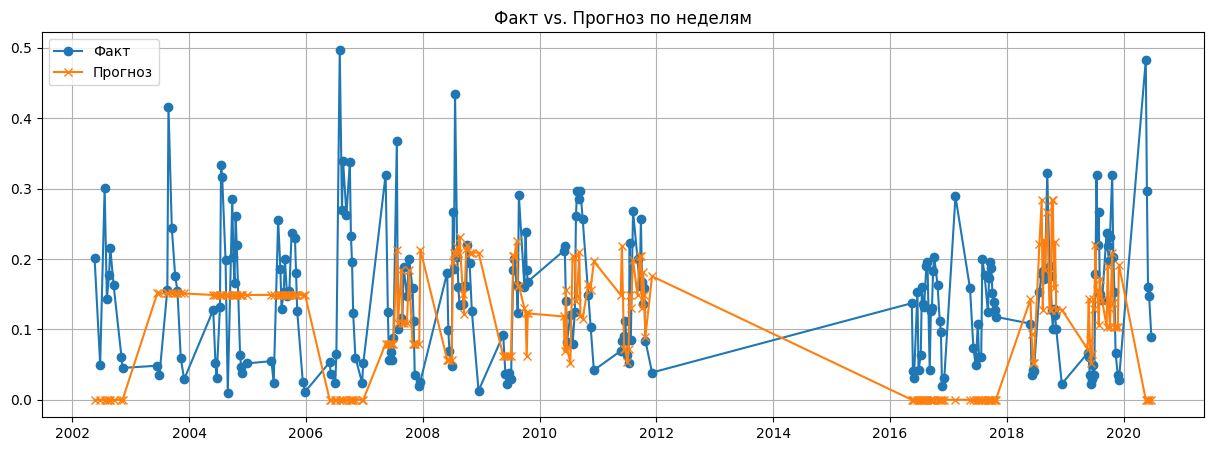


Итоговые метрики без плохих лет:
MSE: 0.0090
RMSE: 0.0950
R²: -0.1239


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# --- Загрузка данных (оставляем твою часть без изменений) ---
# Загрузка Y
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"

df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

r_all = r1.merge(r2, on='date').merge(r3, on='date')

# Нормализация R и Y
for col in ['R1', 'R2', 'R3']:
    p99 = r_all[col].quantile(0.99)
    r_all[col] = r_all[col].clip(upper=p99) / p99

p99_y = df_y['chlorophyll'].quantile(0.99)
df_y['chlorophyll'] = df_y['chlorophyll'].clip(upper=p99_y) / p99_y

# Группировка по неделям
r_all['week'] = r_all['date'].dt.to_period('W').apply(lambda r: r.start_time)
df_y['week'] = df_y['date'].dt.to_period('W').apply(lambda r: r.start_time)

r_weekly = r_all.groupby('week')[['R1', 'R2', 'R3']].mean().reset_index()
y_weekly = df_y.groupby('week')['chlorophyll'].mean().reset_index()

df_weekly = pd.merge(r_weekly, y_weekly, on='week', how='inner')

# --- Готовим данные для модели ---
X = df_weekly[['R1', 'R2', 'R3']].values
y = df_weekly['chlorophyll'].values
weeks = df_weekly['week'].values
years = pd.to_datetime(weeks).year

# Годы, которые нужно исключить из теста
bad_years = [2006, 2016, 2017, 2020]

# --- Накопительная кросс-валидация ---
y_pred = np.zeros_like(y)
model = HistGradientBoostingRegressor(random_state=42, max_iter=100)

for i in range(1, len(np.unique(years))):
    train_years = np.unique(years)[:i]
    test_year = np.unique(years)[i]

    if test_year in bad_years:
        continue  # пропускаем плохие года для теста

    train_idx = np.isin(years, train_years)
    test_idx = years == test_year

    model.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = model.predict(X[test_idx])

# --- Оценка качества ---
df_result = df_weekly[['week']].copy()
df_result['y_true'] = y
df_result['y_pred'] = y_pred
df_result['year'] = pd.to_datetime(df_result['week']).dt.year

# Исключаем плохие годы из подсчета метрик
df_eval = df_result[~df_result['year'].isin(bad_years)]

r2_by_year = df_eval.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_eval.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

print("\nR² по годам (без плохих лет):")
print(r2_by_year)
print("\nMSE по годам (без плохих лет):")
print(mse_by_year)

# --- График: предсказание vs. факт ---
plt.figure(figsize=(15, 5))
plt.plot(df_result['week'], df_result['y_true'], label='Факт', marker='o')
plt.plot(df_result['week'], df_result['y_pred'], label='Прогноз', marker='x')
plt.legend()
plt.grid()
plt.title('Факт vs. Прогноз по неделям')
plt.show()

# --- Графики: факт и предсказание + траектории R1, R2, R3 (Plotly) ---
import plotly.subplots as sp

for year in sorted(df_result['year'].unique()):
    if year in bad_years:
        continue

    df_year = df_result[df_result['year'] == year]
    df_features = df_weekly[df_weekly['week'].isin(df_year['week'])]

    fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
                           subplot_titles=(f'{year}: Факт vs. Прогноз', 'R1, R2, R3'))

    # График факта и прогноза
    fig.add_trace(go.Scatter(x=df_year['week'], y=df_year['y_true'], mode='lines+markers', name='Факт'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_year['week'], y=df_year['y_pred'], mode='lines+markers', name='Прогноз'), row=1, col=1)

    # График спутниковых R
    fig.add_trace(go.Scatter(x=df_features['week'], y=df_features['R1'], mode='lines+markers', name='R1'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df_features['week'], y=df_features['R2'], mode='lines+markers', name='R2'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df_features['week'], y=df_features['R3'], mode='lines+markers', name='R3'), row=2, col=1)

    fig.update_layout(height=700, title_text=f'Год: {year}', showlegend=True)
    fig.show()

# --- Итоговые метрики ---
mse = mean_squared_error(df_eval['y_true'], df_eval['y_pred'])
rmse = np.sqrt(mse)
r2 = r2_score(df_eval['y_true'], df_eval['y_pred'])

print(f"\nИтоговые метрики без плохих лет:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Пути
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"

s1_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_3000_матрица_из_ячеек_все_годы.csv"
s2_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_4500_матрица_из_ячеек_все_годы.csv"
s3_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_6000_матрица_из_ячеек_все_годы.csv"

# Загрузка Y
df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

# Загрузка R
def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

r_all = r1.merge(r2, on='date').merge(r3, on='date')

# Загрузка S
def load_s(path, name):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    # Переименовываем колонки
    df.columns = [f'{name}_{col}' for col in df.columns]
    return df

s1 = load_s(s1_path, 'S1')
s2 = load_s(s2_path, 'S2')
s3 = load_s(s3_path, 'S3')

# --- Нормализация R и Y ---
for col in ['R1', 'R2', 'R3']:
    p99 = r_all[col].quantile(0.99)
    r_all[col] = r_all[col].clip(upper=p99) / p99

p99_y = df_y['chlorophyll'].quantile(0.99)
df_y['chlorophyll'] = df_y['chlorophyll'].clip(upper=p99_y) / p99_y

# --- Группировка по неделям ---
r_all['week'] = r_all['date'].dt.to_period('W').apply(lambda r: r.start_time)
df_y['week'] = df_y['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Сгруппируем R по неделям (усреднение)
r_weekly = r_all.groupby('week')[['R1', 'R2', 'R3']].mean()

# Сгруппируем Y по неделям (усреднение)
y_weekly = df_y.groupby('week')['chlorophyll'].mean()

# Сгруппируем S по неделям (усредним по датам в неделе)
s1_weekly = s1.groupby(pd.Grouper(freq='W-MON')).mean()
s2_weekly = s2.groupby(pd.Grouper(freq='W-MON')).mean()
s3_weekly = s3.groupby(pd.Grouper(freq='W-MON')).mean()

# Переименуем индекс у s_weekly для совместимости (неделя начинается с понедельника)
# Чтобы совпадали с r_all и y_weekly, у которых недели начинаются с понедельника
s1_weekly.index = s1_weekly.index.to_period('W').to_timestamp()
s2_weekly.index = s2_weekly.index.to_period('W').to_timestamp()
s3_weekly.index = s3_weekly.index.to_period('W').to_timestamp()

# --- Объединяем все признаки ---
X_df = pd.concat([r_weekly, s1_weekly, s2_weekly, s3_weekly], axis=1)

# Убираем недели, где нет всех данных (например, в начале/конце)
df_weekly = pd.concat([X_df, y_weekly], axis=1).dropna()

# --- Создаем лаги (1, 2, 3 недели) для всех признаков ---
for lag in [1, 2, 3]:
    lagged = df_weekly.iloc[:, :-1].shift(lag)
    lagged.columns = [f'{col}_lag{lag}' for col in lagged.columns]
    df_weekly = pd.concat([df_weekly, lagged], axis=1)

# Убираем NaN после сдвигов
df_weekly = df_weekly.dropna()

# --- Подготовка для модели ---
X = df_weekly.drop(columns=['chlorophyll']).values
y = df_weekly['chlorophyll'].values
weeks = df_weekly.index
years = weeks.year.values

# Года, которые нужно исключить из теста
#bad_years = [2006, 2016, 2017, 2020]

# --- Накопительная кросс-валидация ---
from sklearn.ensemble import HistGradientBoostingRegressor

y_pred = np.zeros_like(y)
model = HistGradientBoostingRegressor(random_state=42, max_iter=100)

years_y = df_y['week'].dt.year.unique()
years_r = r_all['week'].dt.year.unique()

unique_years = np.intersect1d(years_y, years_r)
for i in range(1, len(unique_years)):
    train_years = unique_years[:i]
    test_year = unique_years[i]

    if test_year in bad_years:
        continue  # пропускаем плохие года для теста

    train_idx = np.isin(years, train_years)
    test_idx = years == test_year

    model.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = model.predict(X[test_idx])

# --- Оценка качества ---
df_result = pd.DataFrame({
    'week': weeks,
    'y_true': y,
    'y_pred': y_pred,
    'year': years
})

df_eval = df_result[~df_result['year'].isin(bad_years)]

r2_by_year = df_eval.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_eval.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

print("\nR² по годам (без плохих лет):")
print(r2_by_year)
print("\nMSE по годам (без плохих лет):")
print(mse_by_year)

mse = mean_squared_error(df_eval['y_true'], df_eval['y_pred'])
rmse = np.sqrt(mse)
r2 = r2_score(df_eval['y_true'], df_eval['y_pred'])

print(f"\nИтоговые метрики без плохих лет:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


ValueError: Found array with 0 sample(s) (shape=(0, 51696)) while a minimum of 1 is required by HistGradientBoostingRegressor.

In [44]:
print(s1_path.head)

AttributeError: 'str' object has no attribute 'head'

In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Загрузка данных (твой код без изменений)
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y1_(глубина_=_0).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"
s1_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_3000_матрица_из_ячеек_все_годы.csv"
s2_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_4500_матрица_из_ячеек_все_годы.csv"
s3_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_6000_матрица_из_ячеек_все_годы.csv"

df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

r_all = r1.merge(r2, on='date').merge(r3, on='date')
r_features = r_all[['R1', 'R2', 'R3']]
r_p95 = r_features.quantile(0.99)
r_clipped = r_features.clip(upper=r_p95, axis=1)
r_normalized = r_clipped / r_p95
r_normalized['date'] = r_all['date']

def load_s(path, name):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df.columns = [f'{name}_{col}' for col in df.columns]
    return df

s1 = load_s(s1_path, 'S1')
s2 = load_s(s2_path, 'S2')
s3 = load_s(s3_path, 'S3')

df_x = r_normalized.copy()
df_x = df_x.set_index('date')
df_x = df_x.join([s1, s2, s3])
df_x = df_x.reset_index()

df = pd.merge(df_x, df_y, on='date', how='inner')
df = df.dropna(subset=['chlorophyll'])

features = df.drop(columns=['date', 'chlorophyll', 'R1', 'R2', 'R3'])  # только S
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

X_scaled = pd.concat([df[['R1', 'R2', 'R3']].reset_index(drop=True), features_scaled], axis=1)
X_scaled['date'] = df['date'].values
y = df['chlorophyll']
groups = df['date'].dt.year

model = HistGradientBoostingRegressor(random_state=42, max_iter=100)
logo = LeaveOneGroupOut()
y_pred = cross_val_predict(model, X_scaled.drop(columns='date'), y, cv=logo, groups=groups)

df_result = df[['date', 'R1', 'R2', 'R3']].copy()
df_result['y_true'] = y
df_result['y_pred'] = y_pred
df_result['year'] = df_result['date'].dt.year
df_result['R_avg'] = df_result[['R1', 'R2', 'R3']].mean(axis=1)

# --- Вычисляем MSE по каждому году ---
mse_r1 = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['R1']))
mse_r2 = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['R2']))
mse_r3 = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['R3']))
mse_r_avg = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['R_avg']))
mse_model = df_result.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

# --- Собираем все в один DataFrame ---
df_metrics = pd.DataFrame({
    'Year': mse_r1.index,
    'MSE_R1_vs_Y': mse_r1.values,
    'MSE_R2_vs_Y': mse_r2.values,
    'MSE_R3_vs_Y': mse_r3.values,
    'MSE_R_avg_vs_Y': mse_r_avg.values,
    'MSE_Model_vs_Y': mse_model.values
})

# --- Сохраняем в CSV ---
output_path = "C:/Users/fusb1/Desktop/mse_by_year.csv"
df_metrics.to_csv(output_path, index=False)

print(f"Файл успешно сохранен: {output_path}")


Файл успешно сохранен: C:/Users/fusb1/Desktop/mse_by_year.csv


C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\4103603691.py:80: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\4103603691.py:81: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\4103603691.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a f

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Пути
y1_path = "C:/Users/fusb1/Desktop/После Рыбки/Y_глубины/Y2_(глубина_=_5).csv"
r1_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_3_daily_Mean_Chla.csv"
r2_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_4.5_daily_Mean_Chla.csv"
r3_path = "C:/Users/fusb1/Desktop/После Рыбки/R_хлорофилл_спутник/Sputnik_radius_6_daily_Mean_Chla.csv"

s1_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_3000_матрица_из_ячеек_все_годы.csv"
s2_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_4500_матрица_из_ячеек_все_годы.csv"
s3_path = "C:/Users/fusb1/Desktop/Для диплома/Для_диплома_комп/ОЧИЩЕНО_6000_матрица_из_ячеек_все_годы.csv"

# Загрузка Y
df_y = pd.read_csv(y1_path)
df_y.columns = ['date', 'chlorophyll']
df_y['date'] = pd.to_datetime(df_y['date'])
df_y['chlorophyll'] = df_y['chlorophyll'].astype(str).str.replace(r'[^0-9,\.]', '', regex=True).str.replace(',', '.')
df_y['chlorophyll'] = pd.to_numeric(df_y['chlorophyll'], errors='coerce')

# Загрузка R
def load_r(path, name):
    df = pd.read_csv(path)
    df = df[['date', 'chla_mean']]
    df = df.rename(columns={'chla_mean': name})
    df['date'] = pd.to_datetime(df['date'])
    return df

r1 = load_r(r1_path, 'R1')
r2 = load_r(r2_path, 'R2')
r3 = load_r(r3_path, 'R3')

r_all = r1.merge(r2, on='date').merge(r3, on='date')

# Загрузка S
def load_s(path, name):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df.columns = [f'{name}_{col}' for col in df.columns]
    return df

s1 = load_s(s1_path, 'S1')
s2 = load_s(s2_path, 'S2')
s3 = load_s(s3_path, 'S3')

# --- Нормализация R и Y ---
for col in ['R1', 'R2', 'R3']:
    p99 = r_all[col].quantile(0.99)
    r_all[col] = r_all[col].clip(upper=p99) / p99

p99_y = df_y['chlorophyll'].quantile(0.99)
df_y['chlorophyll'] = df_y['chlorophyll'].clip(upper=p99_y) / p99_y

# --- Группировка по неделям ---
r_all['week'] = r_all['date'].dt.to_period('W').apply(lambda r: r.start_time)
df_y['week'] = df_y['date'].dt.to_period('W').apply(lambda r: r.start_time)

r_weekly = r_all.groupby('week')[['R1', 'R2', 'R3']].mean()
y_weekly = df_y.groupby('week')['chlorophyll'].mean()

s1_weekly = s1.groupby(pd.Grouper(freq='W-MON')).mean()
s2_weekly = s2.groupby(pd.Grouper(freq='W-MON')).mean()
s3_weekly = s3.groupby(pd.Grouper(freq='W-MON')).mean()

s1_weekly.index = s1_weekly.index.to_period('W').to_timestamp()
s2_weekly.index = s2_weekly.index.to_period('W').to_timestamp()
s3_weekly.index = s3_weekly.index.to_period('W').to_timestamp()

# --- Объединяем все признаки ---
X_df = pd.concat([r_weekly, s1_weekly, s2_weekly, s3_weekly], axis=1)

df_weekly = pd.concat([X_df, y_weekly], axis=1).dropna()

# --- Лаги ---
for lag in [1, 2, 3]:
    lagged = df_weekly.iloc[:, :-1].shift(lag)
    lagged.columns = [f'{col}_lag{lag}' for col in lagged.columns]
    df_weekly = pd.concat([df_weekly, lagged], axis=1)

df_weekly = df_weekly.dropna()

# --- Подготовка ---
X = df_weekly.drop(columns=['chlorophyll']).values
y = df_weekly['chlorophyll'].values
weeks = df_weekly.index
years = weeks.year.values

# --- Накопительная кросс-валидация ---
y_pred = np.zeros_like(y)
model = HistGradientBoostingRegressor(random_state=42, max_iter=100)

years_y = df_y['week'].dt.year.unique()
years_r = r_all['week'].dt.year.unique()

unique_years = np.intersect1d(years_y, years_r)

for i in range(1, len(unique_years)):
    train_years = unique_years[:i]
    test_year = unique_years[i]

    train_idx = np.isin(years, train_years)
    test_idx = years == test_year

    if np.sum(train_idx) == 0 or np.sum(test_idx) == 0:
        print(f"Skipping year {test_year} due to insufficient data.")
        continue

    print(f"Train years: {train_years}, Test year: {test_year}")
    print(f"Train size: {np.sum(train_idx)}, Test size: {np.sum(test_idx)}")

    model.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = model.predict(X[test_idx])

# --- Оценка ---
df_result = pd.DataFrame({
    'week': weeks,
    'y_true': y,
    'y_pred': y_pred,
    'year': years
})

df_eval = df_result  # Оцениваем по всем годам

r2_by_year = df_eval.groupby('year').apply(lambda d: r2_score(d['y_true'], d['y_pred']))
mse_by_year = df_eval.groupby('year').apply(lambda d: mean_squared_error(d['y_true'], d['y_pred']))

print("\nR² по годам:")
print(r2_by_year)
print("\nMSE по годам:")
print(mse_by_year)

mse = mean_squared_error(df_eval['y_true'], df_eval['y_pred'])
rmse = np.sqrt(mse)
r2 = r2_score(df_eval['y_true'], df_eval['y_pred'])

print(f"\nИтоговые метрики:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Skipping year 2003 due to insufficient data.
Skipping year 2004 due to insufficient data.
Skipping year 2005 due to insufficient data.
Skipping year 2006 due to insufficient data.
Train years: [2002 2003 2004 2005 2006], Test year: 2007
Train size: 2, Test size: 1
Skipping year 2008 due to insufficient data.
Skipping year 2009 due to insufficient data.
Train years: [2002 2003 2004 2005 2006 2007 2008 2009], Test year: 2010
Train size: 3, Test size: 1
Skipping year 2011 due to insufficient data.
Skipping year 2012 due to insufficient data.
Train years: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012], Test year: 2016
Train size: 4, Test size: 13
Train years: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2016], Test year: 2017
Train size: 17, Test size: 10
Train years: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2016 2017], Test year: 2018
Train size: 27, Test size: 15
Train years: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2016 2017 2018], Test

c:\Users\fusb1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

c:\Users\fusb1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\3173148416.py:129: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\fusb1\AppData\Local\Temp\ipykernel_8208\3173148416.py:130: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of p